<a href="https://colab.research.google.com/github/Neena-A/Final-Proj/blob/main/Copy_of_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

cp: cannot stat 'kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip /content/chest-xray-pneumonia.zip

unzip:  cannot find or open /content/chest-xray-pneumonia.zip, /content/chest-xray-pneumonia.zip.zip or /content/chest-xray-pneumonia.zip.ZIP.


In [ ]:
from keras.models import load_model
from keras.layers import Activation,Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

In [ ]:
def Build_CNN_Model():   
    # -------------------------------------------------------------------------
    #                        Transfer VGG Model 
    # -------------------------------------------------------------------------
    # load ResNet model
    ResNet = ResNet50(include_top=True, input_shape=(224, 224, 3))
     
    # mark loaded layers as not trainable
    for layer in ResNet.layers:
	    layer.trainable = False        

    # mark loaded layers as trainable
    for layer in ResNet.layers[100:]:
	    layer.trainable = True 
    
    #  Softmax Classifier
    Class_layer = Dense(2)(ResNet.layers[-2].output)
    
    Softmax_layer = Activation('softmax')(Class_layer)
        
	# define new model    
    model = Model(inputs=ResNet.inputs, outputs=Softmax_layer)
            
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 

     

    


In [ ]:
   
# train and evalluate cnn model
def Train_CNN_Model(model):
    
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,                                     
                                     brightness_range=[0.2,1.0],
                                     )
    
    valid_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
   
   
    # prepare iterators
    batch_size=32
    train_it = train_datagen.flow_from_directory('/content/chest_xray/train',batch_size=batch_size, target_size=(224, 224))
    valid_it = valid_datagen.flow_from_directory('/content/chest_xray/val/',batch_size=batch_size, target_size=(224, 224))


    epochs=10;
    
    history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=valid_it, validation_steps=len(valid_it), epochs=epochs, verbose=1)
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

	# save model
    model.save('medical_diagnosis_cnn_model.h5')

In [ ]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('medical_diagnosis_cnn_model.h5')
    
    # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
    test_it = test_datagen.flow_from_directory('/content/chest_xray/test', 
                                               shuffle=False,batch_size=batch_size, target_size=(224, 224))
    
    y_true = test_it.classes;

    y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:,1]

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary));
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()
    


In [ ]:
# main entry
    
model = Build_CNN_Model()



102967424/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 2399s 15s/step - loss: 0.5029 - accuracy: 0.7732 - val_loss: 141.1955 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 2423s 15s/step - loss: 0.3352 - accuracy: 0.8439 - val_loss: 0.9507 - val_accuracy: 0.5625
Epoch 3/10
163/163 [==============================] - 2405s 15s/step - loss: 0.3044 - accuracy: 0.8639 - val_loss: 37.8408 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 2402s 15s/step - loss: 0.2858 - accuracy: 0.8740 - val_loss: 2.9876 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 2424s 15s/step - loss: 0.2634 - accuracy: 0.8909 - val_loss: 44.6835 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 2401s 15s/step - loss: 0.2568 - accuracy: 0.8896 - val_loss: 25.0960 - val_accuracy: 0.5000
Epoch 7/10
163/163 [=======================

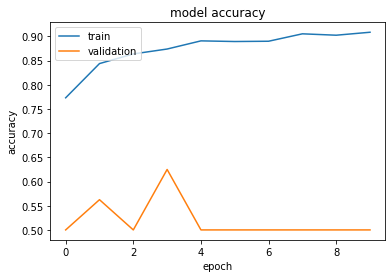

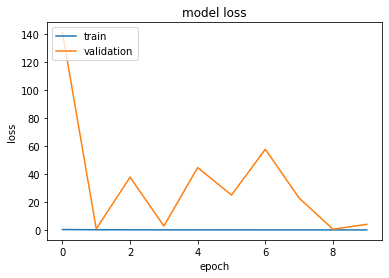

In [ ]:
Train_CNN_Model(model)
    


In [ ]:
Evaluate_CNN_Model()

NameError: ignored